## Strange Network Development

In [24]:
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [28]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [3]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

Ingest the landsat imagery stacked into yearly seasonal tiles

In [4]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [5]:
tile_size = 1
tile_list = ['028012', '029011', '028011']
class_count = 6
epochs = 200
batch_size = 25

# The next two cells are for making pixels and prepping them for training (balancing)
### This is unnecessary to run because I already saved them to text files so now you load them

In [ ]:
px = rnn_pixels.make_pixels(tile_size, tile_list)
px_to_use = px[:1000]
pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use, tile_size)

In [ ]:
# gets balanced pixels locations 
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=False)
total_labels = list()
count = 0
#buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

while count < len(pixels):
        image_b, label_b = next(w_generator)
        label_b = np.argmax(label_b)
        buckets[label_b].append(pixels[count]) # appends pixels to dictionary
        total_labels.append(label_b)
        count+=1
total_labels = np.asarray(total_labels)
total_labels = total_labels.reshape(len(total_labels)*tile_size*tile_size)
#weights_list = class_weight.compute_class_weight('balanced', np.unique(total_labels), total_labels)
count = 0 
for z, j in buckets.items():
    print(len(j))
    count += len(j)
print(count) 
use_px = []
use_px+=buckets[0][:3000]
use_px+=(buckets[1][:3000])
use_px+=(buckets[2][:3000])
use_px+=(buckets[3][:3000])
use_px+=(buckets[4][:3000])
use_px+=(buckets[5][:3000])
random.shuffle(use_px)
train_px, val_px, test_px = rnn_pixels.train_val_test_split(use_px, 0.7, 0.7)

# Load pixels

In [6]:
train_px, val_px, test_px = util.read_txt(['train_px.txt', 'val_px.txt', 'test_px.txt'])
train_px = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, train_px, tile_size)
val_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, val_px, tile_size)
test_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, test_px, tile_size)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
1000
2000
3000
1000
2000


### Create the RNN

In [7]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [8]:
def make_MLT_dense(in_shape, num_classes):
    input_tensor = Input(shape = in_shape)
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    landcover = LSTM(num_classes,activation='softmax', return_sequences=False, name='landcover') (block_2)
    canopy = LSTM(1, return_sequences=False, name='canopy') (block_2)
    model = Model(inputs=input_tensor, outputs=[landcover, canopy])
    return model

In [9]:
model = make_MLT_dense((4,7), class_count)
#model.load_weights('mlt_dense_model.hdf5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 7)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 4, 12)        960         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 4, 19)        0           input_1[0][0]                    
                                                                 lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)       

In [153]:
#model = keras.models.load_model('dense_model.h5')

#### Train the Model

In [10]:
filepath = 'mlt_dense_model_pcg.hdf5'#your filepath here
checkpoint = ModelCheckpoint(filepath, monitor='val_landcover_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [14]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy', 'canopy':'mae'}, metrics={'landcover':['accuracy'], 'canopy':['mae']}, loss_weights={"landcover":1, "canopy":1})

In [15]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                   validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                  validation_steps=len(val_px) // batch_size, callbacks=callbacks_list)# class_weight=weights_list)# callbacks=callbacks_list) #class_weight=weights, callbacks=callbacks_list) 

Epoch 1/200
470/470 [==============================] - 50s 106ms/step - loss: 0.6891 - landcover_loss: 0.6313 - canopy_loss: 0.0578 - landcover_acc: 0.7938 - canopy_mean_absolute_error: 0.0578 - val_loss: 0.6126 - val_landcover_loss: 0.5578 - val_canopy_loss: 0.0548 - val_landcover_acc: 0.8142 - val_canopy_mean_absolute_error: 0.0548

Epoch 00001: val_landcover_acc improved from -inf to 0.81418, saving model to mlt_dense_model_pcg.hdf5
Epoch 2/200
470/470 [==============================] - 41s 87ms/step - loss: 0.6681 - landcover_loss: 0.6091 - canopy_loss: 0.0590 - landcover_acc: 0.7975 - canopy_mean_absolute_error: 0.0590 - val_loss: 0.6006 - val_landcover_loss: 0.5449 - val_canopy_loss: 0.0557 - val_landcover_acc: 0.8201 - val_canopy_mean_absolute_error: 0.0557

Epoch 00002: val_landcover_acc improved from 0.81418 to 0.82014, saving model to mlt_dense_model_pcg.hdf5
Epoch 3/200
470/470 [==============================] - 41s 87ms/step - loss: 0.6340 - landcover_loss: 0.5777 - canopy_

KeyboardInterrupt: 

In [ ]:
model.save('mlt_dense_pcg.h5')

### Inspect Training Data

In [92]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True), steps=len(train_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)

11750/11750 [==============================] - 298s 25ms/step


In [95]:
lc_predictions_train = np.asarray(predictions[0])
canopy_pred_train = np.asarray(predictions[1])
lc_predictions_train = np.argmax(lc_predictions_train,axis=-1)

In [97]:
lc_lab_train = np.empty(lc_predictions_train.shape)
canopy_true_train = np.empty(canopy_pred_train.shape)
count = 0
while count < len(lc_predictions_train):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true_train[count] = label_b['canopy']
        lc_lab_train[count] = label_lc
        count += 1
label_index = lc_lab_train.reshape(len(train_px)*tile_size*tile_size)
pred_index = lc_predictions_train.reshape(len(train_px)*tile_size*tile_size)

((array([7641.,  323.,  600.,  366.,  299.,  223.,  233.,  293.,  490.,
         1282.]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  <a list of 10 Patch objects>),
 (array([7321.,  790.,  538.,  362.,  245.,  180.,  173.,  189.,  364.,
         1588.]),
  array([-0.07,  0.04,  0.15,  0.25,  0.36,  0.46,  0.57,  0.68,  0.78,
          0.89,  1.  ], dtype=float32),
  <a list of 10 Patch objects>))

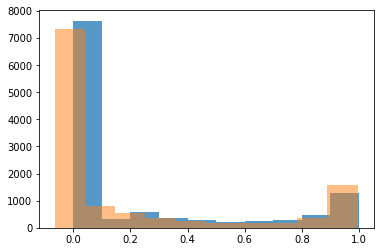

In [102]:
plt.hist(canopy_true_train, alpha=0.75), plt.hist(canopy_pred_train, alpha=0.5)

In [104]:
from sklearn.metrics import r2_score
r2_score(canopy_true_train, canopy_pred_train)

0.8630009401022725

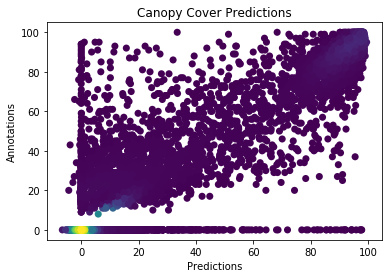

In [103]:
from scipy.stats import gaussian_kde

x = (canopy_pred_train * 100).flatten()
y = (canopy_true_train * 100).flatten()

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()

fig,ax = plt.subplots()
ax.scatter(x,y,c=z,s=50,edgecolor='')
ax.set_xlabel("Predictions")
ax.set_ylabel("Annotations")
ax.set_title("Canopy Cover Predictions")
plt.show()

# Evaluate model

In [114]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(test_px, batch_size=1, flatten=True, canopy=True), steps=len(test_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(test_px, batch_size=1, flatten=True, canopy=True)

2570/2570 [==============================] - 66s 26ms/step


In [115]:
lc_predictions = np.asarray(predictions[0])
canopy_pred = np.asarray(predictions[1])
lc_predictions = np.argmax(lc_predictions,axis=-1)

In [116]:
lc_lab = np.empty(lc_predictions.shape)
canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1
label_index = lc_lab.reshape(len(test_px)*tile_size*tile_size)
pred_index = lc_predictions.reshape(len(test_px)*tile_size*tile_size)

Accuracy is 0.8031128404669261


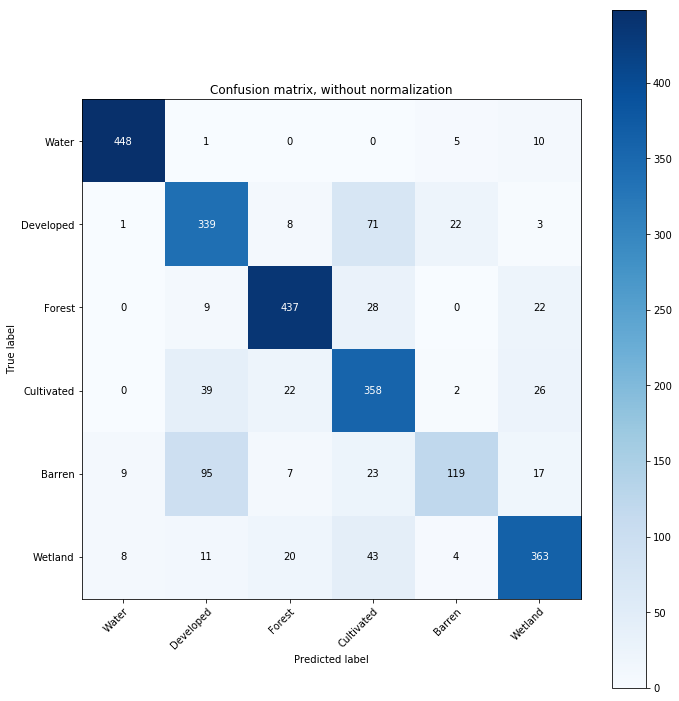

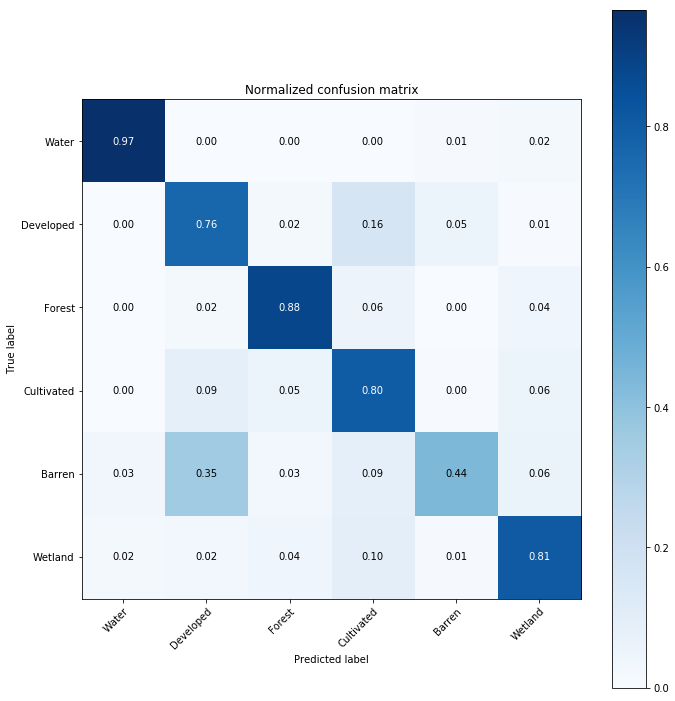

In [76]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True)
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("Accuracy is {}".format(count/len(label_index)))

plt.savefig("confusion_matrix.png", dpi=1000)

In [53]:
total = 0
tot = 0
for count in range(len(canopy_pred)):
    if canopy_true[count] != 0 and canopy_pred[count] !=0:
        if canopy_pred[count] < 0:
            canopy_pred[count] = 0
        total+= np.absolute(canopy_pred[count] - canopy_true[count])
        tot+=1
print(total/tot)

[0.14]


In [120]:
label_index.shape

(2570,)

In [ ]:
label_index, 

In [126]:
import pandas as pd
pred_df = pd.DataFrame({'lc_pred': pred_index,
                        'lc_true': label_index,
                        'canopy_pred': canopy_pred.flatten(),
                        'canopy_true': canopy_true.flatten()})
pred_df[pred_df["lc_true"] == 0].head()

,canopy_pred,canopy_true,lc_pred,lc_true
11,0.0,0.0,0,0.0
19,0.0,0.0,0,0.0
21,0.0,0.0,0,0.0
22,0.0,0.0,0,0.0
25,0.0,0.0,0,0.0


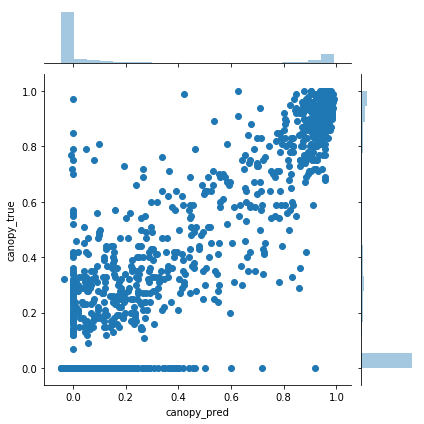

In [134]:
sns.jointplot(pred_df['canopy_pred'], y=pred_df['canopy_true'], kind='scatter')

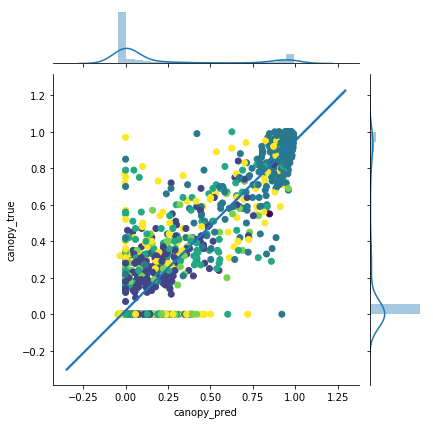

In [146]:
g = sns.jointplot(x=pred_df['canopy_pred'], y=pred_df['canopy_true'], kind='reg', scatter=False)

g.ax_joint.scatter(x=pred_df['canopy_pred'], y=pred_df['canopy_true'], c=pred_df['lc_true'])

(array([1614.,  166.,  100.,   66.,   51.,   37.,   33.,   38.,   81.,
         384.]),
 array([-0.04,  0.06,  0.16,  0.27,  0.37,  0.47,  0.58,  0.68,  0.78,
         0.89,  0.99], dtype=float32),
 <a list of 10 Patch objects>)

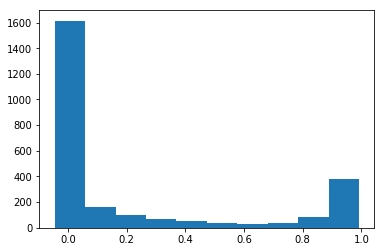

In [141]:
plt.hist(canopy_pred)

(array([1642.,   70.,  130.,   84.,   64.,   56.,   41.,   55.,  112.,
         316.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

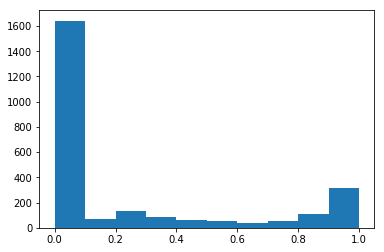

In [142]:
plt.hist(canopy_true)

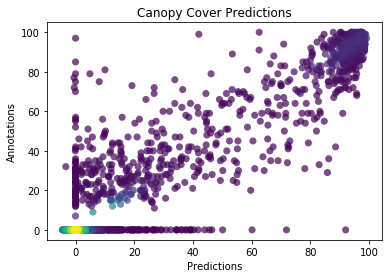

In [152]:
from scipy.stats import gaussian_kde

x = (canopy_pred * 100).flatten()
y = (canopy_true * 100).flatten()


xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()

fig,ax = plt.subplots()
ax.scatter(x,y,c=z,s=50,edgecolor='', alpha=0.7)
ax.set_xlabel("Predictions")
ax.set_ylabel("Annotations")
ax.set_title("Canopy Cover Predictions")
plt.savefig("canopy_regression.png", dpi=1000)

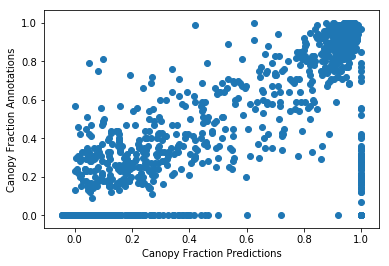

In [79]:
plt.scatter(canopy_pred, canopy_true)
plt.xlabel("Canopy Fraction Predictions")
plt.ylabel("Canopy Fraction Annotations")
plt.savefig("canopy_regression.png", dpi=1000)

In [140]:
from sklearn.metrics import r2_score
r2_score(canopy_true, canopy_pred)

0.8923155662094036

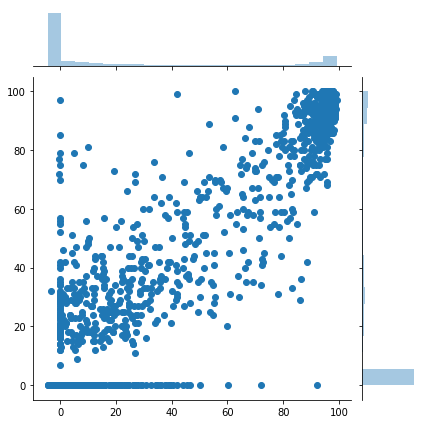

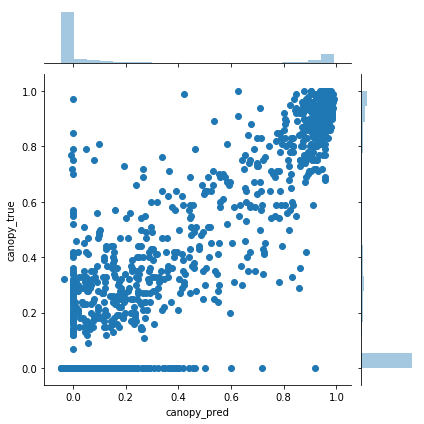

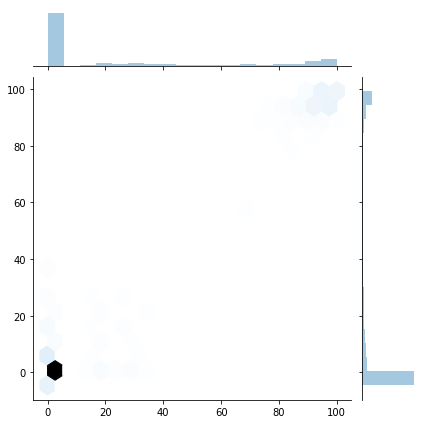

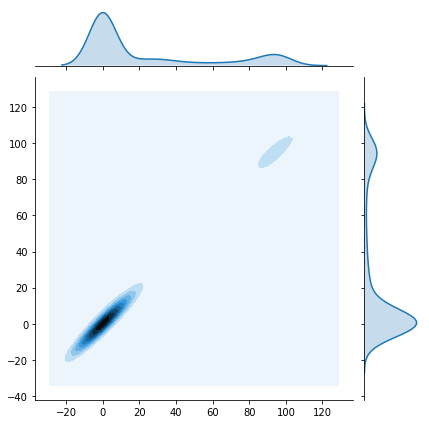

In [137]:
# library & dataset
import seaborn as sns
df = sns.load_dataset('iris')
 

sns.jointplot(y=(canopy_true*100).flatten(), x=(canopy_pred*100).flatten(), kind='scatter')
sns.jointplot(pred_df['canopy_pred'], y=pred_df['canopy_true'], kind='scatter')

sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='hex')
sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='kde')
